In [1]:
## Kaggle Competition 1 - Simo Hakim - 20096040

ratio = 0.8
###################### -- Imports -- ######################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import xgboost as xgb

import threading
np.random.seed(42)
np.set_printoptions(precision=2, suppress=True)


###################### -- Data Handling -- ######################

### J'importe mes données
test = np.genfromtxt('https://raw.githubusercontent.com/Herbrax/3913TP1/main/test.csv', delimiter=',', skip_header=1)
train = np.genfromtxt('https://raw.githubusercontent.com/Herbrax/3913TP1/main/train.csv', delimiter=',', skip_header=1)
np.random.shuffle(train)

### Je garde une liste de mes labels
unique_labels = np.unique(train[:, -1])

## Integer Labels pour SVM
training_labels = train[:, -1]

## One-hot Labels pour LR
training_labels_one_hot = np.zeros((train.shape[0], unique_labels.shape[0]))  # just the shape
for i, label in enumerate(unique_labels):
    training_labels_one_hot[train[:, -1] == label, i] = 1   # je remplis notre structure de données d'étiquettes one_hot

### Je supprime les colonnes qui ne sont pas à normaliser.
exclude_columns_train = [0, -1, -2]  # SNo, time, label
train_data = np.delete(train, exclude_columns_train, axis=1)

exclude_columns_test = [0, -1]  # SNo, time
test_data = np.delete(test, exclude_columns_test, axis=1)

### Je divise mes données d'entrainement en données d'entrainement et de validation avec un ratio de 80/20 :
split_ratio = int(ratio * len(train_data))

## Données d'entrainement et de validation :
split_train_data = train_data[:split_ratio]
split_validation_data = train_data[split_ratio:]

## Labels d'entrainement et de validation (Integers) (Pour SVM)
split_train_label = training_labels[:split_ratio]
split_validation_label = training_labels[split_ratio:]

## Labels d'entrainement et de validation (One-Hot) (Pour LR)
split_train_label_one_hot = training_labels_one_hot[:split_ratio]
split_validation_label_one_hot = training_labels_one_hot[split_ratio:]

### Je normalise les données d'entrainement et de validation
train_mean = split_train_data.mean(axis=0)
train_std = split_train_data.std(axis=0)

split_train_normalized = (split_train_data - train_mean) / train_std
split_validation_normalized = (split_validation_data - train_mean) / train_std  # J'utilise la moyenne et l'écart-type des données d'entrainement

### Je normalise les données de test en utilisant la moyenne et l'écart-type des données d'entrainement
test_normalized = (test_data - train_mean) / train_std


###################### -- Helper Functions -- ######################
### Pour sauver mes prédictions :
def save_predictions_to_csv(filename, predictions):
    with open(filename, 'w') as file:
        file.write("SNo,Label\n")
        for index, pred in enumerate(predictions, 1):
            file.write(f"{index},{int(pred)}\n")

### Self explanatory
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / exp_z.sum(axis=1, keepdims=True)


###################### -- Implémentation Logistical Regression -- ######################
class LogisticalRegression:
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def train(self, features, oh_labels, validation_data):
        num_samples, num_features = features.shape
        num_classes = oh_labels.shape[1] # Le nombre de classes est déduit des étiquettes one-hot #

        # Initialisation des poids et du biais #
        self.weights = np.random.rand(num_features, num_classes)
        self.bias = np.zeros((1, num_classes))

        for epoch in range(self.epochs):
            linear_model = np.dot(features, self.weights) + self.bias # Calcul du modèle linéaire #
            probabilities = softmax(linear_model)  # Utilisation de la fonction softmax personnalisée #

            # Descente de gradient sur le poids et le biais
            dW = (1 / num_samples) * np.dot(features.T, (probabilities - oh_labels))
            db = (1 / num_samples) * np.sum(probabilities - oh_labels, axis=0)

            # Mise a jour du poids et des biais
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db

    # Calcul des prédictions
    def compute_predictions(self, features):
        linear_model = np.dot(features, self.weights) + self.bias
        probabilities = softmax(linear_model)
        return np.argmax(probabilities, axis=1)

    # Calcul de l'accuracy
    def compute_accuracy(self, preds, labels):
        return np.mean(preds == np.argmax(labels, axis=1))

###################### -- Import SVM Scikit-learn -- ######################

# SVM Linéaire
# Implémentation de Scikit-learn
class LinearSVMClassifier:
    def __init__(self, C):
        self.svm = LinearSVC(C=C, dual=False, max_iter=100000)  # J'ai set dual car mon nombre d'échantillons est plus grand que le nombre de features et max_iter à 100000 pour éviter les erreurs

    # Entrainement du modèle
    def train(self, features, labels):
        self.svm.fit(features, labels)

    # Calcul des prédictions
    def compute_predictions(self, features):
        return self.svm.predict(features)

    # Calcul de l'accuracy
    def compute_accuracy(self, preds, labels):
        return np.mean(preds == labels)

###################### -- Import XGBoost  -- ######################
# Implémentation de XGBoost
class XGBoostClassifier:
    def __init__(self, max_depth, eta, num_class):

        if num_class is None: # Si on ne spécifie pas le nombre de classes, on le déduit des étiquettes
            num_class = len(np.unique(training_labels))

        self.params = { # Paramètres de l'algorithme
            'objective': 'multi:softmax', # Car classification multiclasse
            'num_class': num_class, # déduit plus haut
            'booster': 'dart', # gbtree est plus rapide though mais dart prévient le surapprentissage
            'eval_metric': 'merror', # car classification multiclasse
            'eta': eta, # learning rate
            'max_depth': max_depth, # profondeur maximale de l'arbre
        }

    # Entrainement du modèle
    def train(self, train_data, train_labels, validation_data, validation_labels):

        # Création des structures de données pour XGBoost
        dtrain = xgb.DMatrix(train_data, label=train_labels)
        dval = xgb.DMatrix(validation_data, label=validation_labels)
        # Création d'une liste de validation pour l'entrainement
        watchlist = [(dtrain, 'train'), (dval, 'validation')]
        # Entrainement du modèle
        self.model = xgb.train(self.params, dtrain, num_boost_round=200, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)

    # Calcul des prédictions
    def compute_predictions(self, data):
        ddata = xgb.DMatrix(data)
        predictions = self.model.predict(ddata)
        return predictions
    # Calcul de l'accuracy
    def compute_accuracy(self, preds, labels):
        return np.mean(preds == labels)

###################### -- Plotter les résultats -- ######################
# Self explanatory, je fais que plotter en fait en utilisant matplotlib
def plot_results_LR(results):
    learning_rates = [x[0] for x in results]
    epochs = [x[1] for x in results]
    accuracies = [x[2] for x in results]

    plt.figure(figsize=(10, 6))
    for lr in set(learning_rates):
        specific_lr = [epoch for epoch, l_rate in zip(epochs, learning_rates) if l_rate == lr]
        specific_acc = [acc for acc, l_rate in zip(accuracies, learning_rates) if l_rate == lr]
        plt.plot(specific_lr, specific_acc, label=f'Learning Rate {lr}')

    plt.title(f'Accuracy for different epochs and learning rates')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_results_SVM_Linear(results):
    C_values = [x[0] for x in results]
    accuracies = [x[1] for x in results]

    plt.figure(figsize=(10, 6))
    plt.plot(C_values, accuracies, marker='o', linestyle='-')

    plt.title('Accuracy for different C values')
    plt.xlabel('C Value')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.show()

def plot_results_XGB(results):
    learning_rates = [x[0] for x in results]
    max_depths = [x[1] for x in results]
    accuracies = [x[2] for x in results]

    plt.figure(figsize=(10, 6))
    for lr in set(learning_rates):
        specific_lr_depths = [depth for depth, l_rate in zip(max_depths, learning_rates) if l_rate == lr]
        specific_acc = [acc for acc, l_rate in zip(accuracies, learning_rates) if l_rate == lr]
        plt.plot(specific_lr_depths, specific_acc, label=f'Learning Rate {lr}')

    plt.title(f'Accuracy for different max depths and learning rates')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


###################### -- Code d'entrainement LR -- ######################
def startLR():
    # Optimisation d'hyperparamètres :
    learning_rates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    epoch_values = [100,200,300,400,500,600,700,800,900,1000,2000]
    results_LR = []
    best_acc_logistic = 0
    best_learning_rate = None
    best_epochs = None


    def train(lr, epoch):
        nonlocal best_acc_logistic, best_learning_rate, best_epochs
        print(f"Training with learning rate: {lr}, epochs: {epoch}\n")
        # Définition du modèle sur hyperparamètres
        lr_model = LogisticalRegression(learning_rate=lr, epochs=epoch)
        # Entrainement du modèle
        lr_model.train(split_train_normalized, split_train_label_one_hot, (split_validation_normalized, split_validation_label_one_hot))
        # Calcul de prédictions et d'accuracy pour les hyperparamètres actuels
        val_preds = lr_model.compute_predictions(split_validation_normalized)
        acc = lr_model.compute_accuracy(val_preds, split_validation_label_one_hot)
        # Si le modèle est meilleur que le meilleur modèle précédent, on le garde
        if acc > best_acc_logistic:
            best_acc_logistic = acc
            best_learning_rate = lr
            best_epochs = epoch
        print(f"Accuracy for learning rate: {lr}, epochs: {epoch} = {acc}\n")
        # On ajoute les résultats à une liste pour plotter les résultats
        results_LR.append((lr, epoch, acc))


    # Je multithread la tache pour optimiser le temps d'entrainement
    threads = []
    for lr in learning_rates:
        for epoch in epoch_values:
            t = threading.Thread(target=train, args=(lr, epoch))
            threads.append(t)
            t.start()

    for t in threads:
        t.join()

    results_LR.sort(key=lambda x: (x[0], x[1]))  # Trie les résultats par learning rate, puis par epoch
    print(f"Best accuracy: {best_acc_logistic} with learning rate: {best_learning_rate} and epochs: {best_epochs}\n")

    # Entrainement du modèle avec les meilleurs hyperparamètres
    best_lr_model = LogisticalRegression(learning_rate=best_learning_rate, epochs=best_epochs)
    best_lr_model.train(split_train_normalized, split_train_label_one_hot, (split_validation_normalized, split_validation_label_one_hot))

    # Calcul des prédictions sur le test set et enregistrement dans un fichier CSV
    test_preds = best_lr_model.compute_predictions(test_normalized)
    save_predictions_to_csv(f"lr_predictions_{best_learning_rate}_{best_epochs} - {ratio}.csv", test_preds)

    # Plot des résultats pour les différents hyperparamètres
    plot_results_LR(results_LR)


###################### -- Code d'entrainement SVM Linear -- ######################
def startSVM_Linear():
    # Optimisation d'hyperparamètres :
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    results_SVM_Linear = []
    best_acc_svm = 0
    best_C = 0

    # Fonction pour train mon modèle sur le C value
    def train(C):
        nonlocal best_acc_svm, best_C
        print(f"Training with C value: {C}\n")
        # Définition du modèle sur hyperparamètre
        svm_model = LinearSVMClassifier(C=C)
        # Entrainement du modèle sur hyperparamètre
        svm_model.train(split_train_normalized, split_train_label)
        # Calcul de prédictions et d'accuracy pour les hyperparamètres actuels
        val_preds_svm = svm_model.compute_predictions(split_validation_normalized)
        acc = svm_model.compute_accuracy(val_preds_svm, split_validation_label)
        # Si le modèle est meilleur que le meilleur modèle précédent, on le garde
        if acc > best_acc_svm:
            best_acc_svm = acc
            best_C = C
        print(f"Accuracy for C value: {C} = {acc}\n")
        # On ajoute les résultats à une liste pour plotter les résultats
        results_SVM_Linear.append((C, acc))

    # Je multithread la tache pour optimiser le temps d'entrainement
    threads_svm = []
    for C in C_values:
        t = threading.Thread(target=train, args=(C,))
        threads_svm.append(t)
        t.start()

    for t in threads_svm:
        t.join()

    results_SVM_Linear.sort(key=lambda x: x[0])  # Trie les résultats par valeur C
    print(f"Best accuracy for SVM: {best_acc_svm} with C value: {best_C}\n")

    # Entrainement du modèle avec les meilleurs hyperparamètres
    best_svm_linear_model = LinearSVMClassifier(C=best_C)
    best_svm_linear_model.train(split_train_normalized, split_train_label)

    # Calcul des prédictions sur le test set et enregistrement dans un fichier CSV
    test_preds_svm_linear = best_svm_linear_model.compute_predictions(test_normalized)
    save_predictions_to_csv(f"svm_linear_predictions_C{best_C} - {ratio}.csv", test_preds_svm_linear)

    # Plot des résultats pour les différents hyperparamètres
    plot_results_SVM_Linear(results_SVM_Linear)


###################### -- Code d'entrainement XGBoost -- ######################
def startXGBOOST():
    # Optimisation d'hyperparamètres :
    learning_rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    max_depths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    results_XGB = []
    best_acc_xgb = 0
    best_lr = None
    best_depth = None

    # Fonction pour train mon modèle sur deux hyperparamètres (Learning Rate & Max Depth)
    def train(lr, depth):
        nonlocal best_acc_xgb, best_lr, best_depth
        print(f"Training with learning rate: {lr}, max_depth: {depth}\n")
        # Définition du modèle sur hyperparamètres
        xgb_model = XGBoostClassifier(max_depth=depth, eta=lr, num_class=len(np.unique(training_labels)))
        # Entrainement du modèle
        xgb_model.train(split_train_normalized, split_train_label, split_validation_normalized, split_validation_label)
        # Calcul de prédictions et d'accuracy pour les hyperparamètres actuels
        val_preds = xgb_model.compute_predictions(split_validation_normalized)
        acc = xgb_model.compute_accuracy(val_preds, split_validation_label)
        # Si le modèle est meilleur que le meilleur modèle précédent, on le garde
        if acc > best_acc_xgb:
            best_acc_xgb = acc
            best_lr = lr
            best_depth = depth
        print(f"Accuracy for learning rate: {lr}, max_depth: {depth} = {acc}\n")
        # On ajoute les résultats à une liste pour plotter les résultats
        results_XGB.append((lr, depth, acc))

    # Je multithread la tache pour optimiser le temps d'entrainement
    threads = []
    for lr in learning_rates:
        for depth in max_depths:
            t = threading.Thread(target=train, args=(lr, depth))
            threads.append(t)
            t.start()

    for t in threads:
        t.join()

    results_XGB.sort(key=lambda x: (x[0], x[1]))  # Trie les résultats par learning rate, puis par max_depth
    print(f"Best accuracy: {best_acc_xgb} with learning rate: {best_lr}, max_depth: {best_depth}\n")

    # Entrainement du modèle avec les meilleurs hyperparamètres
    best_xgb_model = XGBoostClassifier(max_depth=best_depth, eta=best_lr, num_class=len(np.unique(training_labels)))
    best_xgb_model.train(split_train_normalized, split_train_label, split_validation_normalized, split_validation_label)

    # Calcul des prédictions sur le test set et enregistrement dans un fichier CSV
    test_preds = best_xgb_model.compute_predictions(test_normalized)
    save_predictions_to_csv(f"xgb_predictions_lr{best_lr}_depth{best_depth} - {ratio}.csv", test_preds)

    # Plot des résultats pour les différents hyperparamètres
    plot_results_XGB(results_XGB)


#LR :
# 0.9 split : Best accuracy: 0.6530384271671135 with learning rate: 0.2 and epochs: 300 - Kaggle score : (0.757)
# 0.8 split : Best accuracy: 0.6766085790884718 with learning rate: 0.9 and epochs: 300 - Kaggle score : (0.758)
# 0.75 split : Best accuracy: 0.664343163538874 with learning rate: 0.5 and epochs: 300 - Kaggle score : (0.766)
# 0.7 split : Best accuracy: 0.6732444709211408 with learning rate: 0.2 and epochs: 800 - Kaggle score : (0.755)
# 0.6 split : Best accuracy: 0.6962689901697945 with learning rate: 0.5 and epochs: 800 - Kaggle score : (0.74)

#SVM Linear :
# 0.9 split : Best accuracy for SVM: 0.604781054512958 with C value: 0.01 - Kaggle score : (0.744)
# 0.8 split : Best accuracy for SVM: 0.646112600536193 with C value: 0.01 - Kaggle score : (0.747)
# 0.7 split : Best accuracy for SVM: 0.6474048700573386 with C value: 1000 - Kaggle score : (0.729)
# 0.6 split : Best accuracy for SVM: 0.6834785522788204 with C value: 0.1 - Kaggle score : (0.731)

#XG Boost gbtree :
# 0.9 split : Best accuracy: 0.6899016979445934 with learning rate: 0.5 and max depth: 7 - Kaggle score : (0.769)
# 0.8 split : Best accuracy: 0.7066577301161752 with learning rate: 0.1 and max depth: 3 - Kaggle score : (0.766)
# 0.75 split : Best accuracy: 0.7072386058981234 with learning rate: 0.25, max_depth: 11 - Kaggle score : (0.758)
# 0.7 split : Best accuracy: 0.7012435773326383 with learning rate: 0.45 and max depth: 8 - Kaggle score : (0.779)
# 0.6 split : Best accuracy: 0.7314008042895442 with learning rate: 0.08 and max depth: 6 - Kaggle score : (0.763)

#XG Boost dart :
# 0.8 Best accuracy: 0.7023011617515639 with learning rate: 0.1, max_depth: 4 - Kaggle score : (0.783)
# 0.75 Best accuracy: 0.7066130473637176 with learning rate: 0.25, max_depth: 11
# 0.7 Best accuracy: 0.7106262566088316 with learning rate: 0.45, max_depth: 8 - Kaggle score : (0.75)

Training with learning rate: 0.1, epochs: 100

Training with learning rate: 0.1, epochs: 200

Training with learning rate: 0.1, epochs: 300

Training with learning rate: 0.1, epochs: 400
Training with learning rate: 0.1, epochs: 500


Training with learning rate: 0.1, epochs: 600

Training with learning rate: 0.1, epochs: 700

Training with learning rate: 0.1, epochs: 800

Training with learning rate: 0.1, epochs: 900

Training with learning rate: 0.1, epochs: 1000

Training with learning rate: 0.1, epochs: 2000

Training with learning rate: 0.2, epochs: 100

Training with learning rate: 0.2, epochs: 200

Training with learning rate: 0.2, epochs: 300

Training with learning rate: 0.2, epochs: 400
Training with learning rate: 0.2, epochs: 500


Training with learning rate: 0.2, epochs: 600

Training with learning rate: 0.2, epochs: 700

Training with learning rate: 0.2, epochs: 800

Training with learning rate: 0.2, epochs: 900

Training with learning rate: 0.2, epochs: 1000

Training w

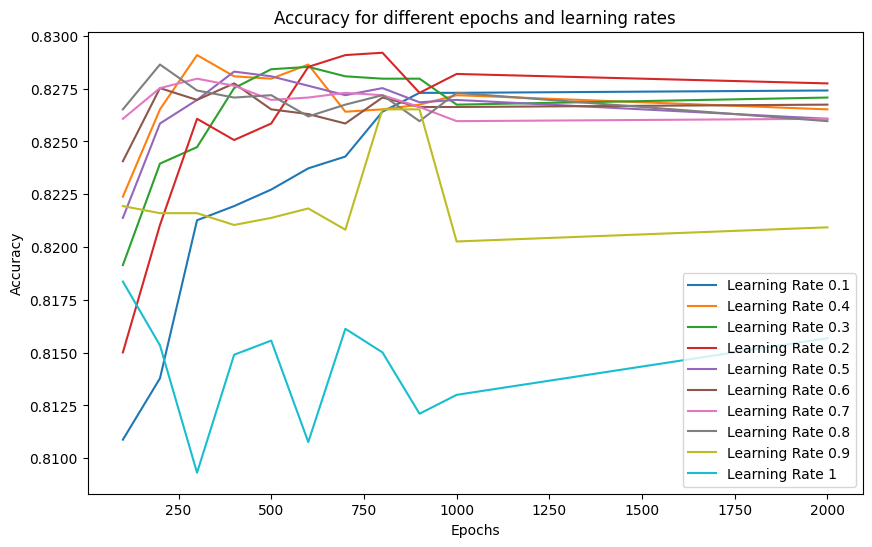

In [2]:
startLR()


Training with C value: 0.001

Training with C value: 0.01

Training with C value: 0.1

Training with C value: 1

Training with C value: 10

Training with C value: 100

Training with C value: 1000

Accuracy for C value: 0.001 = 0.8144548704200179

Accuracy for C value: 0.01 = 0.8194816800714924

Accuracy for C value: 0.1 = 0.821604110813226

Accuracy for C value: 100 = 0.8192582663092046

Accuracy for C value: 10 = 0.8193699731903485

Accuracy for C value: 1 = 0.8197050938337802

Accuracy for C value: 1000 = 0.8192582663092046

Best accuracy for SVM: 0.821604110813226 with C value: 0.1



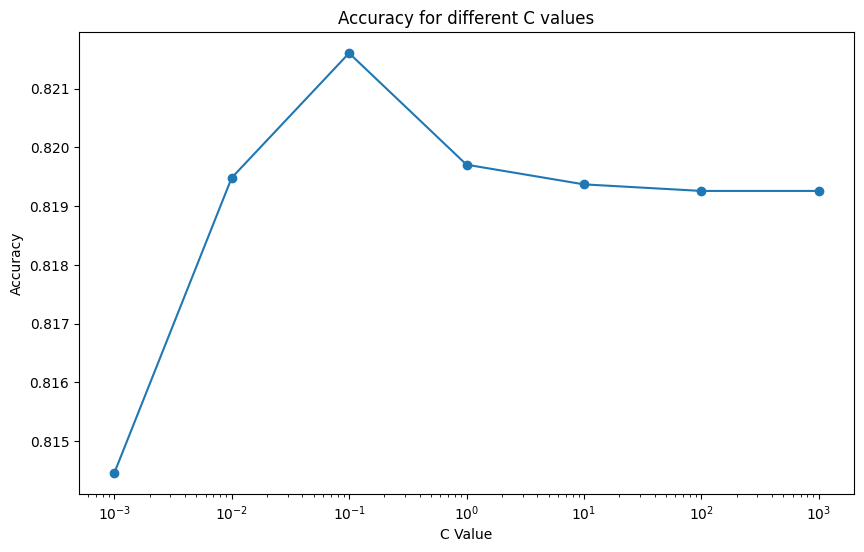

In [3]:
startSVM_Linear()


Training with learning rate: 0.05, max_depth: 3

Training with learning rate: 0.05, max_depth: 4

Training with learning rate: 0.05, max_depth: 5

Training with learning rate: 0.05, max_depth: 6

Training with learning rate: 0.05, max_depth: 7

Training with learning rate: 0.05, max_depth: 8

Training with learning rate: 0.05, max_depth: 9

Training with learning rate: 0.05, max_depth: 10

Training with learning rate: 0.05, max_depth: 11

Training with learning rate: 0.05, max_depth: 12

Training with learning rate: 0.8, max_depth: 3

Training with learning rate: 0.8, max_depth: 4

Training with learning rate: 0.8, max_depth: 5

Training with learning rate: 0.8, max_depth: 6

Training with learning rate: 0.8, max_depth: 7

Training with learning rate: 0.8, max_depth: 8

Training with learning rate: 0.8, max_depth: 9

Training with learning rate: 0.8, max_depth: 10

Training with learning rate: 0.8, max_depth: 11

Training with learning rate: 0.8, max_depth: 12

Training with learning r

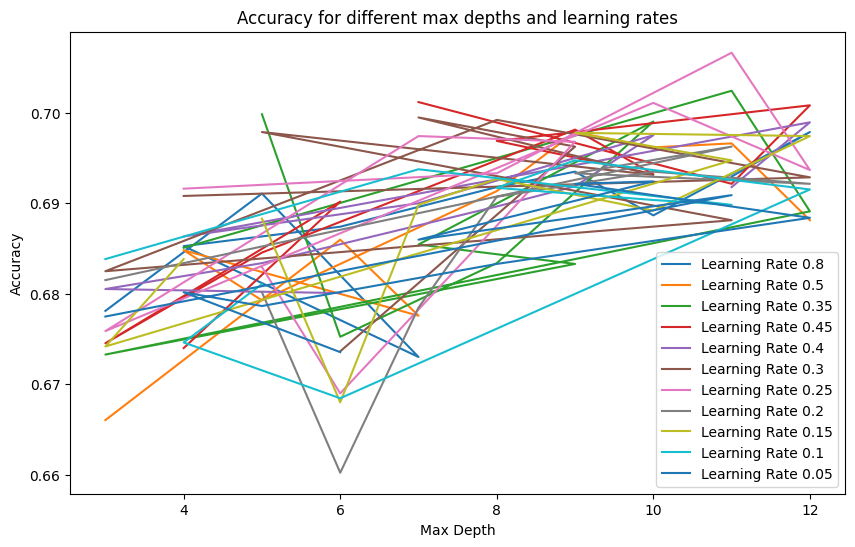

In [ ]:
startXGBOOST()


In [ ]:
startXGBOOST()

Training with learning rate: 0.05, max_depth: 3

Training with learning rate: 0.05, max_depth: 4
Training with learning rate: 0.05, max_depth: 5


Training with learning rate: 0.05, max_depth: 6

Training with learning rate: 0.05, max_depth: 7

Training with learning rate: 0.05, max_depth: 8

Training with learning rate: 0.05, max_depth: 9

Training with learning rate: 0.05, max_depth: 10

Training with learning rate: 0.05, max_depth: 11

Training with learning rate: 0.05, max_depth: 12

Training with learning rate: 0.1, max_depth: 3

Training with learning rate: 0.1, max_depth: 4

Training with learning rate: 0.1, max_depth: 5

Training with learning rate: 0.1, max_depth: 6

Training with learning rate: 0.1, max_depth: 7

Training with learning rate: 0.1, max_depth: 8

Training with learning rate: 0.1, max_depth: 9

Training with learning rate: 0.1, max_depth: 10

Training with learning rate: 0.1, max_depth: 11

Training with learning rate: 0.15, max_depth: 3
Training with learning ra